## Searching for Zinc Fingers, Coiled Coils, Transmembrane Regions, and Domains in UniProt Annotations

This notebook reproduces Fig. S1

Author: Giulio Tesei

Contact: giulio.tesei@bio.ku.dk

In [3]:
import urllib.parse
import urllib.request
import json
import pandas as pd
import numpy as np
import time
import matplotlib as mpl
import matplotlib.pyplot as plt
from ast import literal_eval
from scipy.stats import binned_statistic, binned_statistic_2d

# function to calculate standard error of the mean
se = lambda x : np.std(x)/np.sqrt(x.size)
se.__name__ = 'SE'

partial_match = ['KRAB','Protein kinase','Collagen-like','Zinc finger','Rab-GAP TBC','BTB','FERM','ZP',
'B30.2/SPRY','SET','PID','Cadherin','Fibronectin type-III','IQ','TSP type-1','Ig-like','ABC transporter',
'EGF-like','CARD','PDZ','SH3','SAM','uDENN','Peptidase S1','Ras-GEF','Ras-associating','Olduvai','EF-hand']

exact_match = ['Transmembrane','Coiled coil','USP','PH','Myosin motor',
'Teneurin N-terminal','Helicase ATP-binding','REJ','cDENN FNIP1/2-type','FH2','C2',
'NR LBD','AGC-kinase C-terminal', 'Myotubularin phosphatase',
'Helicase C-terminal','PCI', 'DDHD',
'G-patch','STAS','Kinesin motor','uDENN FNIP1/2-type', 'PLAC','RID','SCAN box',
'PPM-type phosphatase', 'MDFI','I/LWEQ', 'MARVEL',
'HIG1', 'KAP NTPase', 'CNH','PLA2c',
'MACPF', 'DMAP1-binding', 'Sema','ASD2', 'NACHT', 
'IBB', 'GBD/FH3', 'IF rod', 'PARP catalytic','Sox C-terminal', 'Rho-GAP',
'Pyrin','cDENN FLCN/SMCR8-type','Reticulon','WW']

frequent_domains = partial_match + exact_match

def idr_uniprot_features(df,name,annotation,start_feature,end_feature,exact_match,partial_match):
    features = []
    descriptions = []
    start_index = df.loc[name,'first']
    end_index = df.loc[name,'last']
    folded_counter = np.zeros(end_index-start_index+1)
    if (start_feature < start_index):
        start_feature = start_index
    if (end_feature > end_index):
        end_feature = end_index
    length = end_feature-start_feature
    if length >= 10:
        folded_counter[start_feature-start_index:end_feature-start_index] += 1
        features.append(annotation['type'])
        if annotation['type'] == 'Zinc finger':
            descriptions.append('Zinc finger')
        elif annotation['type'] == 'Coiled coil':
            descriptions.append('Coiled coil')
        elif annotation['type'] == 'Transmembrane':
            descriptions.append('Transmembrane')
        else:
            descriptions.append(annotation['description'])
        for domain in exact_match:
            if domain == descriptions[-1]:
                df.loc[name,domain] += length
        for domain in partial_match:
            if domain in descriptions[-1]:
                df.loc[name,domain] += length
        if descriptions[-1] in ['PH 1','PH 2','PH 3','PH 4']:
            df.loc[name,'PH'] += length
        elif descriptions[-1] in ['C2 1','C2 2','C2 3','C2 4','C2 5','C2 6']:
            df.loc[name,'C2'] += length
        elif descriptions[-1] in ['WW 1','WW 2','WW 3','WW 4']:
            df.loc[name,'WW'] += length
        df.loc[name,'N_Domain'] = np.sum(folded_counter!=0)
        df.loc[name,'Features'] = ', '.join(np.unique(features))
        df.loc[name,'Descriptions'] = ', '.join(np.unique(descriptions))
        
def uniprot_api_features(UniProt_ID,df_FL,df_idrome,df_spot,exact_match,partial_match):
    # Use the uniprot as input to fetch the protein name
    idrome_names = df_idrome.query(f'UniProt_ID == "{UniProt_ID:s}"').index
    spot_names = df_spot.query(f'UniProt_ID == "{UniProt_ID:s}"').index
    url_template_uniprot = "https://rest.uniprot.org/uniprotkb/{}.json"
    url_uniprot = url_template_uniprot.format(UniProt_ID)
    
    with urllib.request.urlopen(url_uniprot) as link:
        data_uniprot = json.loads(link.read().decode())
        try:
            annotations = data_uniprot['features']
        except:
            return 'No features'
        N_FL_UP = data_uniprot['sequence']['length']
        df_FL.loc[UniProt_ID,'N_FL_UP'] = N_FL_UP
        if len(idrome_names) > 0:
            N_FL_IDRome = df_idrome.query(f'UniProt_ID == "{UniProt_ID:s}"').N_FL[0]
            if N_FL_IDRome != N_FL_UP:
                print('length mismatch',N_FL_UP,N_FL_IDRome)
                df_FL.loc[UniProt_ID,'N_FL_IDRome'] = N_FL_IDRome
        if len(spot_names) > 0:
            N_FL_SPOT = df_spot.query(f'UniProt_ID == "{UniProt_ID:s}"').N_FL[0]
            if N_FL_SPOT != N_FL_UP:
                print('length mismatch',N_FL_UP,N_FL_SPOT)
                df_FL.loc[UniProt_ID,'N_FL_SPOT'] = N_FL_SPOT
        if len(annotations) > 0:
            folded_counter_FL = np.zeros(N_FL_UP)
            features = []
            descriptions = []
            for annotation in annotations:
                if annotation['type'] in ['Domain','Zinc finger','Coiled coil','Transmembrane']:
                    start_feature = annotation['location']['start']['value']
                    end_feature = annotation['location']['end']['value']
                    if start_feature == None:
                        length = 0
                    elif end_feature == None:
                        length = 0
                    else:
                        length = end_feature-start_feature
                    if length >= 10:
                        folded_counter_FL[start_feature:end_feature] += 1
                        features.append(annotation['type'])
                        if annotation['type'] == 'Zinc finger':
                            descriptions.append('Zinc finger')
                        elif annotation['type'] == 'Coiled coil':
                            descriptions.append('Coiled coil')
                        elif annotation['type'] == 'Transmembrane':
                            descriptions.append('Transmembrane')
                        else:
                            descriptions.append(annotation['description'])
                        for domain in exact_match:
                            if domain == descriptions[-1]:
                                df_FL.loc[UniProt_ID,domain] += length
                        for domain in partial_match:
                            if domain in descriptions[-1]:
                                df_FL.loc[UniProt_ID,domain] += length
                        if descriptions[-1] in ['PH 1','PH 2','PH 3','PH 4']:
                            df_FL.loc[UniProt_ID,'PH'] += length
                        elif descriptions[-1] in ['C2 1','C2 2','C2 3','C2 4','C2 5','C2 6']:
                            df_FL.loc[UniProt_ID,'C2'] += length
                        elif descriptions[-1] in ['WW 1','WW 2','WW 3','WW 4']:
                            df_FL.loc[UniProt_ID,'WW'] += length
                        df_FL.loc[UniProt_ID,'N_Domain'] = np.sum(folded_counter_FL!=0)
                        df_FL.loc[UniProt_ID,'Features'] = ', '.join(np.unique(features))
                        df_FL.loc[UniProt_ID,'Descriptions'] = ', '.join(np.unique(descriptions))
                        for idrome_name in idrome_names:
                            idr_uniprot_features(df_idrome,idrome_name,annotation,
                                                 start_feature,end_feature,exact_match,partial_match)
                        for spot_name in spot_names:
                            idr_uniprot_features(df_spot,spot_name,annotation,
                                                 start_feature,end_feature,exact_match,partial_match)

In [59]:
# Load IDRome database
df_idrome = pd.read_csv('IDRome_DB.csv',index_col=0)[['nu','SPR','UniProt_ID','N',
                                                      'first','last','N_FL','is_btw_folded','is_nterm',
                                                      'is_cterm','is_idp']]
df_idrome[frequent_domains] = 0
# Load SPOT database
df_spot = pd.read_csv('IDRome_DB_SPOT.csv',index_col=0)[['nu_svr','SPR_svr','UniProt_ID','N',
                                                         'first','last','N_FL','is_btw_folded','is_nterm',
                                                      'is_cterm','is_idp']]
df_spot[frequent_domains] = 0

UniProt_IDs = np.unique(np.append(df_idrome.UniProt_ID,df_spot.UniProt_ID))

# Create FL database
df_FL = pd.DataFrame(index=UniProt_IDs,columns=['N_Domain','Features','Descriptions',
                                               'N_FL_UP','N_FL_IDRome','N_FL_SPOT'])
df_FL[frequent_domains] = 0

len(UniProt_IDs)

15955

In [ ]:
for i,UniProt_ID in enumerate(UniProt_IDs[:]):
    uniprot_api_features(UniProt_ID,df_FL,df_idrome,df_spot,exact_match,partial_match)
    print(i,end='-')
    time.sleep(.6)

In [10]:
df_idrome['N_Domain'] = df_idrome['N_Domain'].fillna(0) 
df_idrome['fdomain'] = df_idrome['N_Domain'] / df_idrome['N']
df_idrome.to_csv('IDRome_DB_Domains.csv')

In [11]:
df_spot['N_Domain'] = df_spot['N_Domain'].fillna(0) 
df_spot['fdomain'] = df_spot['N_Domain'] / df_spot['N']
df_spot.to_csv('IDRome_DB_SPOT_Domains.csv')

In [12]:
df_FL['N_Domain'] = df_FL['N_Domain'].fillna(0) 
df_FL['fdomain'] = df_FL['N_Domain'] / df_FL['N_FL_UP']
df_FL.to_csv('FL_Domains.csv')

In [4]:
# Load domain annotations
df_idrome = pd.read_csv('IDRome_DB_Domains.csv',index_col=0)
df_spot = pd.read_csv('IDRome_DB_SPOT_Domains.csv',index_col=0)
df_FL = pd.read_csv('FL_Domains.csv',index_col=0)

#### Calculate the overlap between pLDDT-based and SPOT-based sets

In [ ]:
cnt_spot = 0
cnt_idrome = 0
for up_id in df_spot.UniProt_ID.unique():
    idrs_idrome = df_idrome.query(f'UniProt_ID == "{up_id:s}"')
    idrs_spot = df_spot.query(f'UniProt_ID == "{up_id:s}"')
    for ndx_spot in idrs_spot.index:
        first_spot = idrs_spot.loc[ndx_spot,'first']
        last_spot = idrs_spot.loc[ndx_spot,'last']
        for ndx_idrome in idrs_idrome.index:
            first = idrs_idrome.loc[ndx_idrome,'first']
            last = idrs_idrome.loc[ndx_idrome,'last']
            if (first_spot >= first) and (last_spot <= last):
                cnt_spot += 1
            elif (first >= first_spot) and (last <= last_spot):
                cnt_idrome += 1

cnt_spot/df_spot.shape[0]*100,cnt_idrome/df_spot.shape[0]*100,(cnt_spot+cnt_idrome)/df_spot.shape[0]*100

In [5]:
df_idrome.Descriptions = df_idrome.Descriptions.apply(lambda x : x.split(',') if type(x)!=float else x)
df_spot.Descriptions = df_spot.Descriptions.apply(lambda x : x.split(',') if type(x)!=float else x)
df_FL.Descriptions = df_FL.Descriptions.apply(lambda x : x.split(',') if type(x)!=float else x)

#### Rename Domains with Shorthand Descriptions

In [6]:
def replace_w_substring(strings,shorthand_description):
    for i,string in enumerate(strings):
        for substring in shorthand_description:
            if substring in string:
                strings[i] = substring
        if string in ['PH 1','PH 2','PH 3','PH 4']:
            strings[i] = 'PH'
        if string in ['C2 1','C2 2','C2 3','C2 4','C2 5','C2 6']:
            strings[i] = 'C2'
        if string in ['WW 1','WW 2','WW 3','WW 4']:
            strings[i] = 'WW'
    if 'Zinc finger' in strings:
        strings = ['Zinc finger']
    if '' in strings:
        strings.remove('')
    return np.unique(strings)

df_idrome['Short_Descriptions'] = df_idrome[~pd.isnull(df_idrome.Descriptions)].Descriptions.apply(
    lambda x : replace_w_substring(x,partial_match))

df_spot['Short_Descriptions'] = df_spot[~pd.isnull(df_spot.Descriptions)].Descriptions.apply(
    lambda x : replace_w_substring(x,partial_match))

df_FL['Short_Descriptions'] = df_FL[~pd.isnull(df_FL.Descriptions)].Descriptions.apply(
    lambda x : replace_w_substring(x,partial_match))

#### Descriptions for IDRs with Multiple Domains of Different Type

In [7]:
df_idrome['Short_Descriptions'] = df_idrome[~pd.isnull(df_idrome.Descriptions)].Short_Descriptions.apply(
    lambda x : ' & '.join([str(s) for s in x]))
df_spot['Short_Descriptions'] = df_spot[~pd.isnull(df_spot.Descriptions)].Short_Descriptions.apply(
    lambda x : ' & '.join([str(s) for s in x]))
df_FL['Short_Descriptions'] = df_FL[~pd.isnull(df_FL.Descriptions)].Short_Descriptions.apply(
    lambda x : ' & '.join([str(s) for s in x]))

In [8]:
df_idrome.query('fdomain > 0.9').shape[0]/df_idrome.shape[0]*100,df_idrome.query('fdomain > 0').shape[0]

(3.432176206429539, 6204)

In [9]:
df_spot.query('fdomain > 0').shape[0]/df_spot.shape[0]*100,df_spot.query('fdomain > 0').shape[0]

(19.150727213206753, 4095)

In [10]:
df_spot.fdomain.mean()

0.06747993214094654

#### Fig. S1 _B_

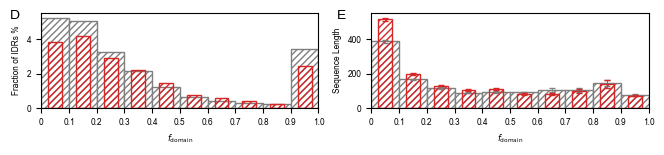

In [13]:
fig, (ax1,ax2) = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(6.6,1.5))
plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 6})

intervals = pd.cut(df_idrome['fdomain'], np.arange(0, 1.05, .1))
fdomain_counts = df_idrome['fdomain'].groupby(intervals).agg(['count'])/df_idrome['fdomain'].size*100
fdomain_counts.plot(rot=0, ax=ax1, kind='bar',hatch='/////',color='w', 
                      edgecolor='tab:gray',width=1,legend=False)

intervals = pd.cut(df_spot['fdomain'], np.arange(0, 1.05, .1))
fdomain_counts = df_spot['fdomain'].groupby(intervals).agg(['count'])/df_spot['fdomain'].size*100
fdomain_counts.plot(rot=0, ax=ax1, kind='bar',hatch='/////',color='None', 
                      edgecolor='tab:red',width=.5,legend=False)

ax1.set_ylabel('Fraction of IDRs %')

ax1.set_xticks([-.5]+(np.arange(fdomain_counts.index.size)+.5).tolist())
ax1.set_xticklabels([0]+[i.right for i in fdomain_counts.index])

intervals = pd.cut(df_idrome['fdomain'], np.arange(0, 1.05, .1))
mean_se = df_idrome['N'].groupby(intervals).agg(['mean',se])
mean_se['mean'].plot(rot=0, ax=ax2, kind='bar', yerr=mean_se['SE'],hatch='/////',color='w',
                      edgecolor='tab:gray',
                      error_kw=dict(ecolor='tab:gray',elinewidth=0.5,capsize=2),width=1)

intervals = pd.cut(df_spot['fdomain'], np.arange(0, 1.05, .1))
mean_se = df_spot['N'].groupby(intervals).agg(['mean',se])
mean_se['mean'].plot(rot=0, ax=ax2, kind='bar', yerr=mean_se['SE'],hatch='/////',color='None',
                      edgecolor='tab:red',
                      error_kw=dict(ecolor='tab:red',elinewidth=0.5,capsize=2),width=.5)

ax2.set_ylabel('Sequence Length')
ax1.set_xlabel(r'$f_{\mathrm{domain}}$')
ax2.set_xlabel(r'$f_{\mathrm{domain}}$')

ax2.set_xticks([-.5]+(np.arange(mean_se.index.size)+.5).tolist())
ax2.set_xticklabels([0]+[i.right for i in mean_se.index])

fig.text(0.01, .9, 'D', fontsize=10)
fig.text(0.506, .9, 'E', fontsize=10)

plt.tight_layout()

fig.savefig('figs/figS1b.pdf',dpi=300)

#### Fig. S1 _C_

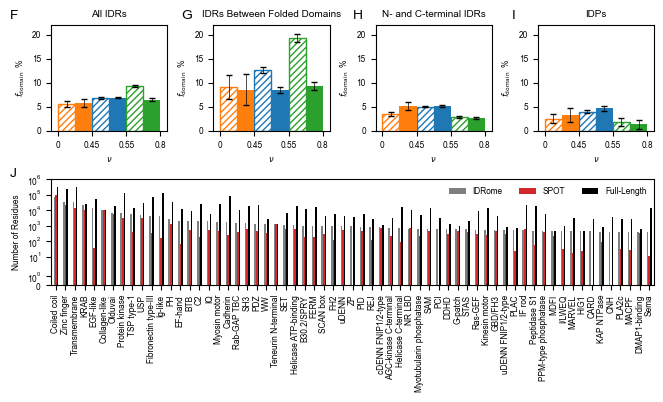

In [22]:
fig = plt.figure(figsize=(6.6,4))
ax1 = plt.subplot2grid( (2,4), (0,0), rowspan=1, colspan=1 )
ax2 = plt.subplot2grid( (2,4), (0,1), rowspan=1, colspan=1 )
ax3 = plt.subplot2grid( (2,4), (0,2), rowspan=1, colspan=1 )
ax4 = plt.subplot2grid( (2,4), (0,3), rowspan=1, colspan=1 )
ax5 = plt.subplot2grid( (2,4), (1,0), rowspan=1, colspan=4 )
plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 6})

# bin nu values
intervals = pd.cut(df_idrome['nu'], np.array([0, .45, .55, .8]))
mean_se = df_idrome['fdomain'].groupby(intervals).agg(['mean',se])*100
mean_se['mean'].plot(rot=0, ax=ax1, kind='bar', yerr=mean_se['SE'],hatch='/////',color='w',
                      error_kw=dict(ecolor='black',elinewidth=0.5,capsize=2),
                      edgecolor=['tab:orange','tab:blue','tab:green'],align='edge',width=-0.5)

# bin nu values
intervals = pd.cut(df_spot['nu_svr'], np.array([0, .45, .55, .8]))
mean_se = df_spot['fdomain'].groupby(intervals).agg(['mean',se])*100
mean_se['mean'].plot(rot=0, ax=ax1, kind='bar', yerr=mean_se['SE'],
                      error_kw=dict(ecolor='black',elinewidth=0.5,capsize=2),
                      color=['tab:orange','tab:blue','tab:green'],align='edge',width=0.5)

ax1.set_xlim(-.7,2.7)
ax1.set_ylim(0,22)
ax1.set_xticks([-.5]+(np.arange(mean_se.index.size)+.5).tolist())
ax1.set_xticklabels([0]+[i.right for i in mean_se.index])

ax1.set_xlabel('$\\nu$')
ax1.set_ylabel(r'$f_{\mathrm{domain}}$  %')

for ax,group in zip([ax2,ax3,ax4],['is_btw_folded','is_nterm or is_cterm','is_idp']):

    # bin nu values
    intervals = pd.cut(df_idrome.query(group)['nu'], np.array([0, .45, .55, .8]))
    mean_se = df_idrome.query(group)['fdomain'].groupby(intervals).agg(['mean',se])*100
    mean_se['mean'].plot(rot=0, ax=ax, kind='bar', yerr=mean_se['SE'],hatch='/////',color='w',
                          error_kw=dict(ecolor='black',elinewidth=0.5,capsize=2),
                          edgecolor=['tab:orange','tab:blue','tab:green'],align='edge',width=-0.5)
    
    #print(group,mean_se['mean'])

    # bin nu values
    intervals = pd.cut(df_spot.query(group)['nu_svr'], np.array([0, .45, .55, .8]))
    mean_se = df_spot.query(group)['fdomain'].groupby(intervals).agg(['mean',se])*100
    mean_se['mean'].plot(rot=0, ax=ax, kind='bar', yerr=mean_se['SE'],
                          error_kw=dict(ecolor='black',elinewidth=0.5,capsize=2),
                          color=['tab:orange','tab:blue','tab:green'],align='edge',width=0.5)
    
    ax.set_xlim(-.7,2.7)
    ax.set_ylim(0,22)
    ax.set_xticks([-.5]+(np.arange(mean_se.index.size)+.5).tolist())
    ax.set_xticklabels([0]+[i.right for i in mean_se.index])
    
    ax.set_xlabel('$\\nu$')
    ax.set_ylabel(r'$f_{\mathrm{domain}}$  %')
    
ax1.set_title('All IDRs')
ax2.set_title('IDRs Between Folded Domains')
ax3.set_title('N- and C-terminal IDRs')
ax4.set_title('IDPs')

counts = pd.DataFrame(columns=['IDRome','SPOT','Full-Length'])
counts['IDRome'] = df_idrome[frequent_domains].sum().sort_values(ascending=False) 
counts['SPOT'] = df_spot[frequent_domains].sum()
counts['Full-Length'] = df_FL[frequent_domains].sum()
#counts = counts[counts>=20]
counts.index
counts.plot.bar(ax=ax5,color=['tab:gray','tab:red','k'])

ax5.set_ylabel('Number of Residues')
ax5.set_yscale('symlog')
ax5.set_ylim(0,1e6)
ax5.set_xlim(-.5,62.5)

ax5.legend(frameon=False,ncol=3)

fig.text(0.01, .955, 'F', fontsize=10)
fig.text(0.27, .955, 'G', fontsize=10)
fig.text(0.53, .955, 'H', fontsize=10)
fig.text(0.77, .955, 'I', fontsize=10)
fig.text(0.01, .56, 'J', fontsize=10)

plt.tight_layout()

fig.savefig('figs/figS1c.pdf',dpi=300)

#### Calculate Average pLDDT Scores

In [13]:
df_pLDDT = pd.read_csv('idr_selection/idr.csv.gz',header=0,sep=';')
df_pLDDT['seq_name'] = df_pLDDT.uniprot+'_'+df_pLDDT['first'].apply(
    lambda x : '{:g}'.format(x))+'_'+df_pLDDT['last'].apply(lambda x : '{:g}'.format(x))
df_pLDDT.set_index('seq_name',inplace=True)
df_pLDDT['is_btw_folded'] = df_idrome.loc[df_pLDDT.index,'is_btw_folded']
df_pLDDT['fdomain'] = df_idrome.loc[df_pLDDT.index,'fdomain']
df_pLDDT['nu'] = df_idrome.loc[df_pLDDT.index,'nu']

df_pLDDT['pLDDT_w20'] = df_pLDDT['pLDDT_w20'].apply(lambda x : 100*np.array(eval(x.replace(':',','))))
pLDDT_w20_idrome = np.array([y for x in df_pLDDT['pLDDT_w20'].values for y in x])

In [24]:
df_pLDDT_spot = pd.read_csv('idr_selection/idr_spot.csv.gz',header=0,sep=';')
df_pLDDT_spot['seq_name'] = df_pLDDT_spot.uniprot+'_'+df_pLDDT_spot['first'].apply(
    lambda x : '{:g}'.format(x))+'_'+df_pLDDT_spot['last'].apply(lambda x : '{:g}'.format(x))
df_pLDDT_spot.set_index('seq_name',inplace=True)
df_pLDDT_spot['is_btw_folded'] = df_spot.loc[df_pLDDT_spot.index,'is_btw_folded']
df_pLDDT_spot['nu_svr'] = df_spot.loc[df_pLDDT_spot.index,'nu_svr']

IDR_no_pLDDT = []
for seq_name in df_pLDDT_spot.index:
    try:
        100*eval(df_pLDDT_spot.loc[seq_name].pLDDT_w20.replace(':',','))
    except NameError:
        IDR_no_pLDDT.append(seq_name)
        
print(df_pLDDT_spot.shape)
df_pLDDT_spot.drop(IDR_no_pLDDT,inplace=True)
print(df_pLDDT_spot.shape)
df_pLDDT_spot['pLDDT_w20'] = df_pLDDT_spot['pLDDT_w20'].apply(lambda x : 100*np.array(eval(x.replace(':',','))))
UniProt_ID_diff = np.unique(np.setxor1d(df_pLDDT_spot.uniprot,df_pLDDT.uniprot))
pLDDT_w20_idrome_spot = np.array([y for x in df_pLDDT_spot['pLDDT_w20'].values for y in x])
pLDDT_w20_unique_spot = np.array([y for x in df_pLDDT_spot[df_pLDDT_spot.uniprot.isin(
    UniProt_ID_diff)]['pLDDT_w20'].values for y in x])

(21383, 11)
(21277, 11)


In [28]:
np.mean([y for x in df_pLDDT.query('is_btw_folded and nu>0.55')['pLDDT_w20'].values for y in x])

55.95874743990514

#### Fig. S1 _A_

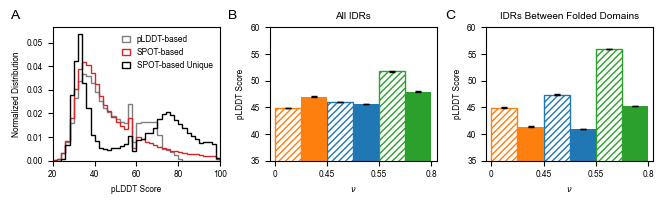

In [21]:
fig, (ax1,ax2,ax3) = plt.subplots(1, 3, sharex=False, sharey=False, figsize=(6.6,2))
plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 6})

bin_width = 2
bins = np.arange(20, 100+bin_width, bin_width)
x = bins[:-1]+bin_width/2

ax1.hist(pLDDT_w20_idrome,
         bins,density=True,histtype='step',
         color='tab:gray',zorder=1,label='pLDDT-based')

ax1.hist(pLDDT_w20_idrome_spot,
         bins,density=True,histtype='step',
         color='tab:red',zorder=1,label='SPOT-based')

ax1.hist(pLDDT_w20_unique_spot,
         bins,density=True,histtype='step',
         color='k',zorder=1,label='SPOT-based Unique')

ax1.set_ylabel('Normalized Distribution')
ax1.set_xlabel(r'pLDDT Score')

ax1.legend(frameon=False,loc='upper right',handlelength=1)
ax1.set_xlim(20,100)

######

f_mean_pLDDT = lambda values : np.mean(np.array([y for x in values for y in x]))
f_mean_pLDDT.__name__ = 'mean_pLDDT'

f_SE_pLDDT = lambda values : se(np.array([y for x in values for y in x]))
f_SE_pLDDT.__name__ = 'SE_pLDDT'

# bin nu values
intervals = pd.cut(df_pLDDT['nu'], np.array([0, .45, .55, .8]))
mean_se = df_pLDDT['pLDDT_w20'].groupby(intervals).agg([f_mean_pLDDT,f_SE_pLDDT])
mean_se['mean_pLDDT'].plot(rot=0, ax=ax2, kind='bar', yerr=mean_se['SE_pLDDT'],hatch='/////',color='w',
                      error_kw=dict(ecolor='black',elinewidth=0.5,capsize=2),
                      edgecolor=['tab:orange','tab:blue','tab:green'],align='edge',width=-0.5)
# bin nu values
intervals = pd.cut(df_spot['nu_svr'], np.array([0, .45, .55, .8]))
mean_se = df_pLDDT_spot['pLDDT_w20'].groupby(intervals).agg([f_mean_pLDDT,f_SE_pLDDT])
mean_se['mean_pLDDT'].plot(rot=0, ax=ax2, kind='bar', yerr=mean_se['SE_pLDDT'],
                      error_kw=dict(ecolor='black',elinewidth=0.5,capsize=2),
                      color=['tab:orange','tab:blue','tab:green'],align='edge',width=0.5)

# bin nu values
intervals = pd.cut(df_pLDDT.query('is_btw_folded')['nu'], np.array([0, .45, .55, .8]))
mean_se = df_pLDDT.query('is_btw_folded')['pLDDT_w20'].groupby(intervals).agg([f_mean_pLDDT,f_SE_pLDDT])
mean_se['mean_pLDDT'].plot(rot=0, ax=ax3, kind='bar', yerr=mean_se['SE_pLDDT'],hatch='/////',color='w',
                      error_kw=dict(ecolor='black',elinewidth=0.5,capsize=2),
                      edgecolor=['tab:orange','tab:blue','tab:green'],align='edge',width=-0.5)

# bin nu values
intervals = pd.cut(df_pLDDT_spot.query('is_btw_folded')['nu_svr'], np.array([0, .45, .55, .8]))
mean_se = df_pLDDT_spot.query('is_btw_folded')['pLDDT_w20'].groupby(intervals).agg([f_mean_pLDDT,f_SE_pLDDT])
mean_se['mean_pLDDT'].plot(rot=0, ax=ax3, kind='bar', yerr=mean_se['SE_pLDDT'],
                      error_kw=dict(ecolor='black',elinewidth=0.5,capsize=2),
                      color=['tab:orange','tab:blue','tab:green'],align='edge',width=0.5)

ax2.set_xticks([-.5]+(np.arange(mean_se.index.size)+.5).tolist())
ax2.set_xticklabels([0]+[i.right for i in mean_se.index])

ax3.set_xticks([-.5]+(np.arange(mean_se.index.size)+.5).tolist())
ax3.set_xticklabels([0]+[i.right for i in mean_se.index])

ax2.set_xlabel('$\\nu$')
ax2.set_ylabel(r'pLDDT Score')
ax2.set_ylim(35,60)
ax2.set_xlim(-.6,2.6)

ax3.set_xlabel('$\\nu$')
ax3.set_ylabel(r'pLDDT Score')
ax3.set_ylim(35,60)
ax3.set_xlim(-.6,2.6)

######

ax2.set_title('All IDRs')
ax3.set_title('IDRs Between Folded Domains')

fig.text(0.01, .92, 'A', fontsize=10)
fig.text(0.34, .92, 'B', fontsize=10)
fig.text(0.67, .92, 'C', fontsize=10)

plt.tight_layout()
plt.savefig('figs/figS1a.pdf')